In [ ]:
# !pip install pandas
# !pip install imbalanced-learn

import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import re

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics, svm, tree
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix,plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from itertools import cycle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBRegressor

%matplotlib inline
pd.set_option('display.max_colwidth', 1000)

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/carolkkw/CIND820_Project/main/data/streaming_imdb2.csv", sep =',', index_col=0)

df.head(3)

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
# drop service_name attribute first
df1 = df.drop(columns = ["service_name"])

# get correlation
corr = df1.corr()
corr

In [ ]:
df1 = df[["imdb_rating","service_name"]]
df1.head(3)

Check skewness along the index axis

In [ ]:
df.skew(axis = 0, skipna = True)

normalize data

In [ ]:
df1 = df1[['imdb_rating']]
df_normalize = df1.apply(lambda x:(x-x.min()) / (x.max()-x.min()))
df_normalize = df_normalize.join(df['service_name'])
df_normalize.head()


check if the numeric attributes are normalized

In [ ]:
df_normalize.describe()

Check imbalanced data

In [ ]:
x = df_normalize.drop('service_name',axis = 'columns')
y = df_normalize['service_name']

y.value_counts()


SMOTE to handling imbalance data

In [ ]:
oversample = SMOTE()
smote = SMOTE(sampling_strategy='minority')
x_sm, y_sm = smote.fit_resample(x,y)

y_sm.value_counts()

divide dataset to training and testing

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size = 0.3, random_state = 42, stratify = y_sm)

check samples

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
for df_normalize in [y_train, y_test]:
    print(df_normalize.describe())

Use the KNN algorithm to predict the streaming service using imdb_rating

In [ ]:
# try k = 5

n5 = KNeighborsClassifier(n_neighbors = 5)
n5.fit(x_train, y_train)
pred_n5 = n5.predict(x_test)
print(classification_report(y_test, pred_n5))

In [ ]:

error_rate = []
for i in range(1,40):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(x_train,y_train)
 pred_i = knn.predict(x_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [ ]:

acc = []

for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
    yhat = neigh.predict(x_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

In [ ]:
# k=14 has the same highest accuracy and loweset error

n = KNeighborsClassifier(n_neighbors = 14)
n.fit(x_train, y_train)
pred_n = n.predict(x_test)
print(classification_report(y_test, pred_n))

In [ ]:
cm = confusion_matrix(y_true = y_test, y_pred = pred_n)
print(cm)

df_cm = pd.DataFrame(cm)
df_cm

In [ ]:
mcm = multilabel_confusion_matrix(y_true = y_test, y_pred = pred_n, labels = y_test.unique())
mcm

try cross-validation model

In [ ]:
# 10-fold cross validation with k for KNN
n = KNeighborsClassifier(n_neighbors = 9)
scores = cross_val_score(n, x_sm, y_sm, cv = 10, scoring = 'accuracy')
print(scores.mean())

In [ ]:
# search for an optimal value of K for KNN using Cross-validation

k_range = range(1,40)
k_scores = []
for k in k_range:
  knn = KNeighborsClassifier(n_neighbors = k)
  scores = cross_val_score(knn, x_sm, y_sm, cv = 10, scoring = 'accuracy')
  k_scores.append(scores.mean())

# plot the value of K for KNN vs the cross-validated accuracy
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

10-fold cross-validation in KNN Model

In [ ]:
# 10-fold cross validation with k for KNN
n = KNeighborsClassifier(n_neighbors = 3)
knn_scores = cross_val_score(n, x_sm, y_sm, cv = 10, scoring = 'accuracy')
print(knn_scores.mean())

10-fold cross-validation in Logistic Regression Model



In [25]:
logreg = LogisticRegression()
logreg_scores = cross_val_score(logreg, x_sm, y_sm, cv = 10, scoring = 'accuracy')
print(logreg_scores.mean())

0.4667310167310167


10-fod cross-valiation in Naive Bayes Model

In [26]:
naibay = MultinomialNB()
naibay_scores = cross_val_score(naibay, x_sm, y_sm, cv = 10, scoring = 'accuracy')
print(naibay_scores.mean())

0.41763191763191765


10-fod cross-valiation in Random Forest Model

In [27]:
ranfor = RandomForestClassifier()
ranfor_scores = cross_val_score(ranfor, x_sm, y_sm, cv = 10, scoring = 'accuracy')
print(ranfor_scores.mean())

0.7913127413127413


10-fod cross-valiation in Decision Tree Model

In [ ]:
dectre = DecisionTreeClassifier()
dectre_scores = cross_val_score(dectre, x_sm, y_sm, cv = 10, scoring = 'accuracy')
print(dectre_scores.mean())

Decision Tree Model without Cross-Validation

In [29]:
clf_model = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=24, min_samples_leaf=28)   
clf_model.fit(x_train,y_train)
y_predict = clf_model.predict(x_test)
accuracy_score(y_test,y_predict)

0.7576147576147576

In [30]:
target = list(df['service_name'].unique())
feature_names = list(x.columns)

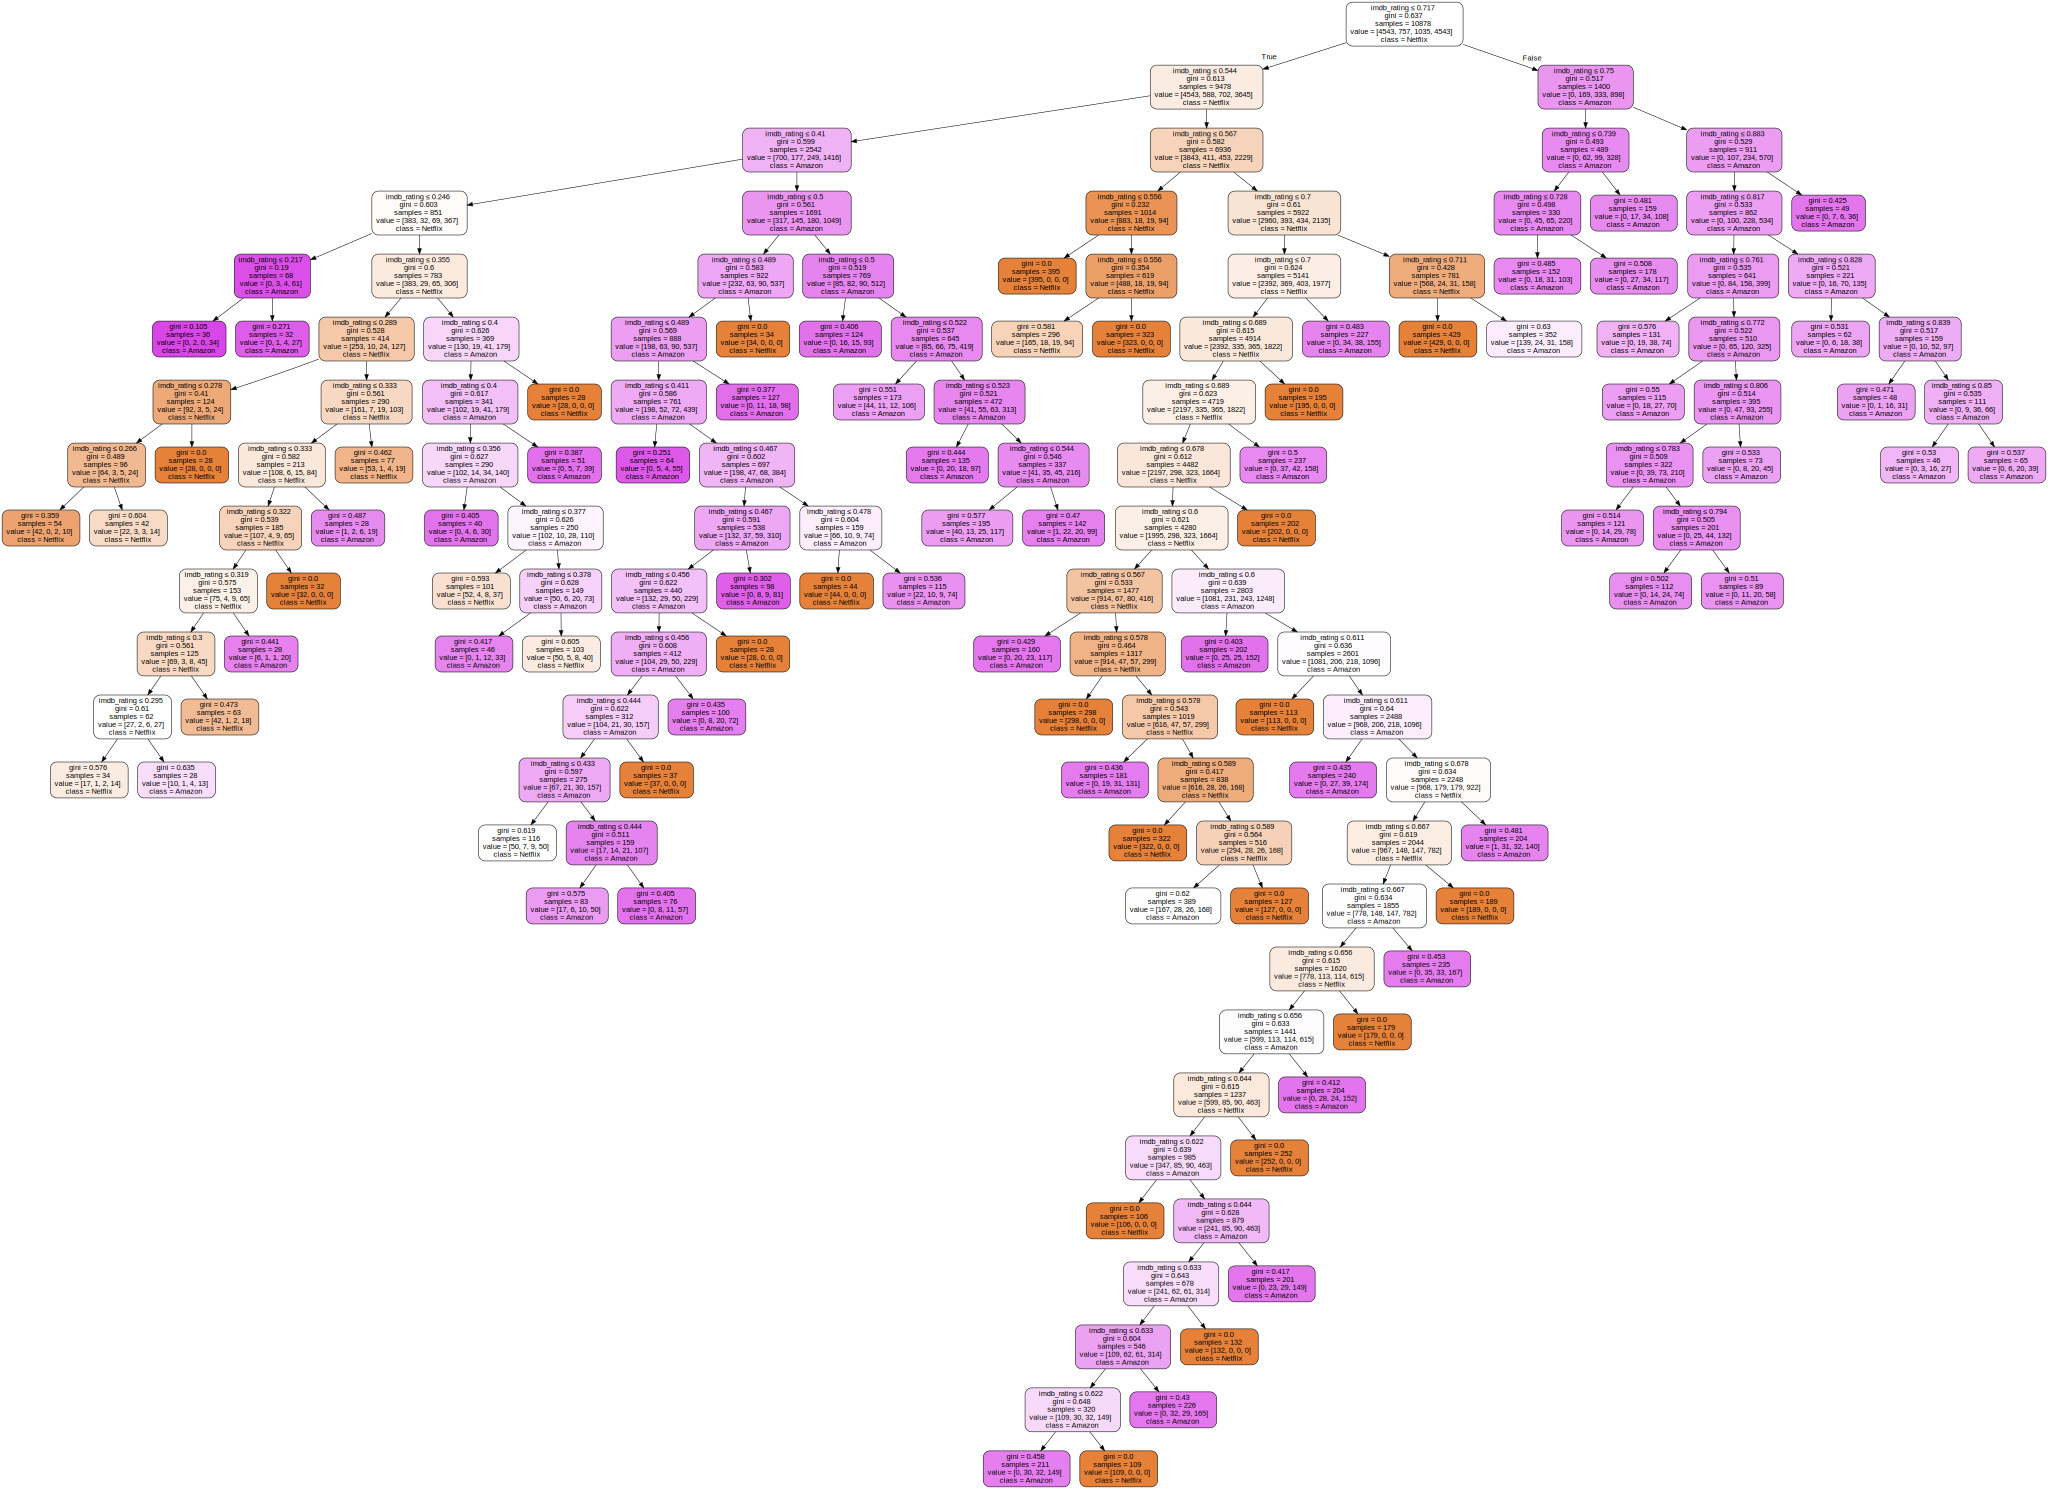

In [31]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
dot_data = tree.export_graphviz(clf_model,
                                out_file=None, 
                      feature_names=feature_names,  
                      class_names=target,  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  

graph